In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === RSI ===
def wilder_rma(series, window):
    return series.ewm(alpha=1/window, adjust=False).mean()

def calc_rsi(data, window=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = wilder_rma(pd.Series(gain), window)
    avg_loss = wilder_rma(pd.Series(loss), window)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === MACD ===
def calc_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# === SuperTrend ===
def compute_supertrend2(df, period=10, multiplier=3):
    hl2 = (df['high'] + df['low']) / 2
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    upperband = hl2 + multiplier * atr
    lowerband = hl2 - multiplier * atr
    in_uptrend = [True]

    for i in range(1, len(df)):
        if df['close'].iloc[i] > upperband.iloc[i - 1]:
            in_uptrend.append(True)
        elif df['close'].iloc[i] < lowerband.iloc[i - 1]:
            in_uptrend.append(False)
        else:
            in_uptrend.append(in_uptrend[i - 1])
            if in_uptrend[i] and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if not in_uptrend[i] and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

    return pd.Series(in_uptrend, index=df.index)

# === Backtest (Alım-Satım Noktalarıyla) ===
# exit_multiplier: alış fiyatının kaç katına ulaştığında satış yapılacağını belirler
def backtest_with_signals(data, rsi, macd, signal, supertrend,
                          rsi_buy, rsi_sell, initial_capital=10000, exit_multiplier=1.5):
    capital = initial_capital
    position = False
    buy_price = 0
    buy_signals = []
    sell_signals = []

    for i in range(1, len(data)):
        close = data['close'].iloc[i]

        if not position and rsi[i] < rsi_buy and macd[i] > signal[i] and supertrend[i]:
            position = True
            buy_price = close
            buy_signals.append((data['date'].iloc[i], close))

        # Çıkış şartı: mevcut exit_multiplier değeri ile belirleniyor
        elif position and (close > buy_price * exit_multiplier):
            position = False
            sell_price = close
            sell_signals.append((data['date'].iloc[i], close))
            pct = (sell_price - buy_price) / buy_price
            capital *= (1 + pct)

    return capital - initial_capital, buy_signals, sell_signals

# === Ana Kod ===
# Veriyi oku ve tarih sütunu yoksa oluştur
data = pd.read_csv('./data_set/Nvidia.csv').head(1000).reset_index(drop=True)
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
else:
    data['date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')  # placeholder tarih

# Sabit parametreler (örneğin, RSI ve MACD için)
macd, signal_line = calc_macd(data, 6, 12, 12)
rsi = calc_rsi(data, 5)
supertrend = compute_supertrend2(data, 10, 8)

# Çıkış katsayısını %30'dan %60'a kadar dene
best_profit = -np.inf
best_exit_multiplier = None
best_buy_signals = None
best_sell_signals = None

# Yüzde değeri olarak; 30% => 1.30, 31% => 1.31, ..., 60% => 1.60
for exit_percent in range(30, 61):
    current_multiplier = 1 + exit_percent / 100.0
    profit, buy_signals, sell_signals = backtest_with_signals(
        data, rsi, macd, signal_line, supertrend, 50, 80, 10000, exit_multiplier=current_multiplier
    )
    # En iyi getiriyi güncelle
    if profit > best_profit:
        best_profit = profit
        best_exit_multiplier = current_multiplier
        best_buy_signals = buy_signals
        best_sell_signals = sell_signals

print("En iyi çıkış katsayısı (exit multiplier):", best_exit_multiplier)
print("Toplam getiri: $", round(best_profit, 2))

En iyi çıkış katsayısı (exit multiplier): 1.5899999999999999
Toplam getiri: $ 103833.88


/var/folders/qz/2658g3zd0mncs35hg48gn9cw0000gn/T/ipykernel_35975/322348920.py:85: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['date'])


/var/folders/qz/2658g3zd0mncs35hg48gn9cw0000gn/T/ipykernel_35975/1132451029.py:87: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['date'])


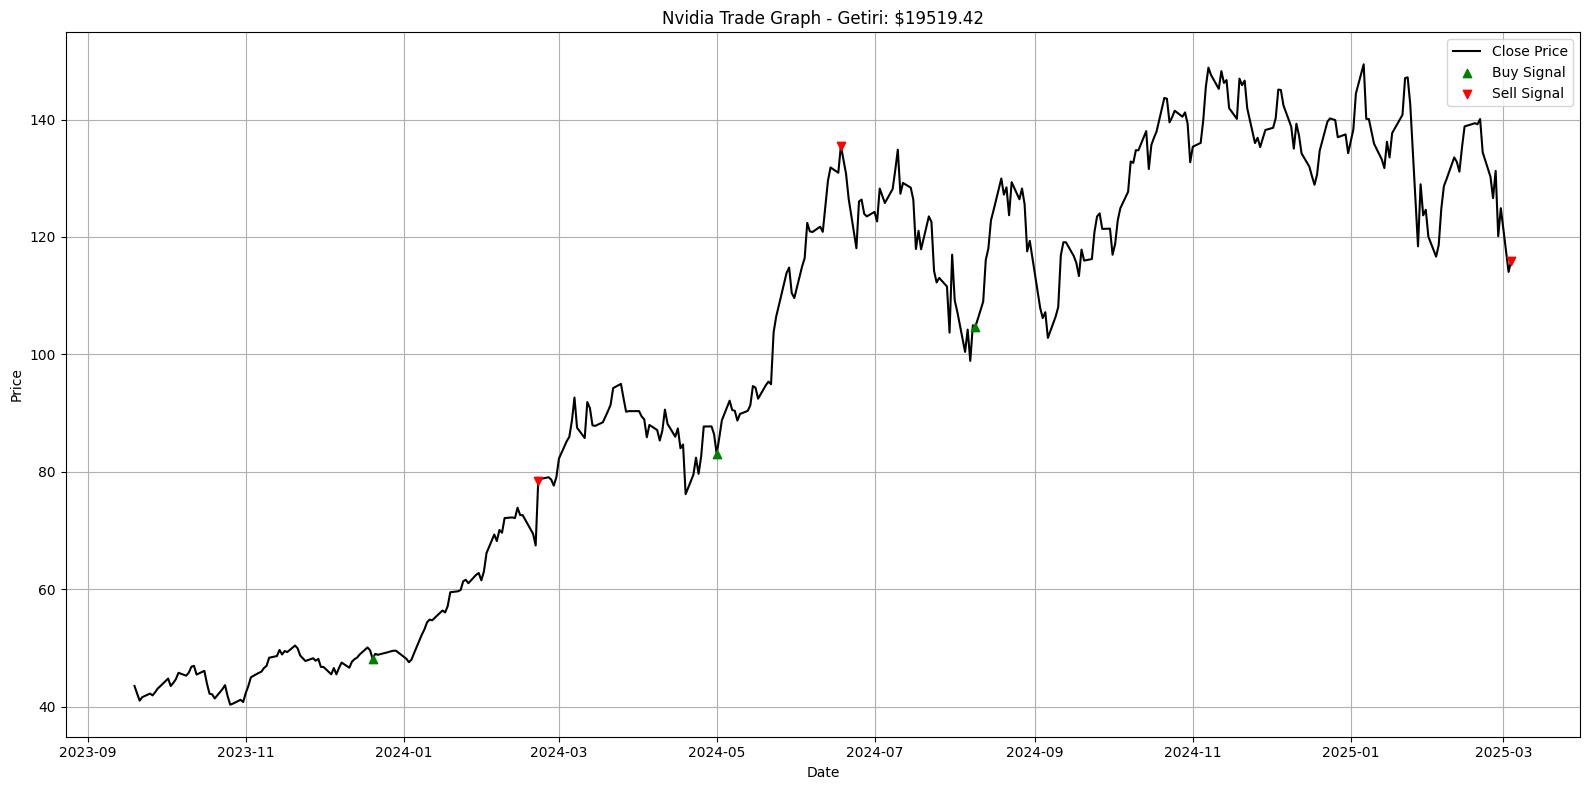

Toplam getiri:  19519.422524735994


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === RSI ===
def wilder_rma(series, window):
    return series.ewm(alpha=1/window, adjust=False).mean()

def calc_rsi(data, window=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = wilder_rma(pd.Series(gain), window)
    avg_loss = wilder_rma(pd.Series(loss), window)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === MACD ===
def calc_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# === SuperTrend ===
def compute_supertrend(df, period=10, multiplier=3):
    hl2 = (df['high'] + df['low']) / 2
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    upperband = hl2 + multiplier * atr
    lowerband = hl2 - multiplier * atr
    in_uptrend = [True]

    for i in range(1, len(df)):
        if df['close'][i] > upperband[i - 1]:
            in_uptrend.append(True)
        elif df['close'][i] < lowerband[i - 1]:
            in_uptrend.append(False)
        else:
            in_uptrend.append(in_uptrend[i - 1])
            if in_uptrend[i] and lowerband[i] < lowerband[i - 1]:
                lowerband[i] = lowerband[i - 1]
            if not in_uptrend[i] and upperband[i] > upperband[i - 1]:
                upperband[i] = upperband[i - 1]

    return pd.Series(in_uptrend, index=df.index)

# === Backtest (Alım-Satım Noktalarıyla) ===
def backtest_with_signals(data, rsi, macd, signal, supertrend,
                          rsi_buy, rsi_sell, initial_capital=10000):
    capital = initial_capital
    position = False
    buy_price = 0
    buy_signals = []
    sell_signals = []

    for i in range(1, len(data)):
        close = data['close'].iloc[i]

        if not position and rsi[i] < rsi_buy and macd[i] > signal[i] and supertrend[i]:
            position = True
            buy_price = close
            buy_signals.append((data['date'].iloc[i], close))

        elif position and (close > buy_price * 1.59):
            position = False
            sell_price = close
            sell_signals.append((data['date'].iloc[i], close))
            pct = (sell_price - buy_price) / buy_price
            capital *= (1 + pct)
    if position:
        # Pozisyon kapatılmadıysa, son fiyat üzerinden hesapla
        sell_price = close
        sell_signals.append((data['date'].iloc[-1], sell_price))
        pct = (sell_price - buy_price) / buy_price
        capital *= (1 + pct)
    return capital - initial_capital, buy_signals, sell_signals

# === Ana Kod ===
data = pd.read_csv('./data_set/Nvidia.csv').tail(365).reset_index(drop=True)
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
else:
    data['date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')  # placeholder tarih

macd, signal = calc_macd(data, 6, 12, 12)
rsi = calc_rsi(data, 5)
supertrend = compute_supertrend(data, 10, 8)

getiri, buy_signals, sell_signals = backtest_with_signals(
    data, rsi, macd, signal, supertrend, 50, 80, 10000
)

# === Grafik ===
plt.figure(figsize=(16, 8))
plt.plot(data['date'], data['close'], label='Close Price', color='black')

# Alım noktaları
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, marker='^', color='green', label='Buy Signal', zorder=5)

# Satım noktaları
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', label='Sell Signal', zorder=5)

plt.title(f'Nvidia Trade Graph - Getiri: ${getiri:.2f}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Toplam getiri: ",getiri)